In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [28]:
ASCIIFILE = '/home/cz489/STEMalign_BO/outscope.txt'
MConHBAR  =  2.59e12
maxsig = 1  # determine how many standard deviations are we going to plot

In [29]:
screen =  np.loadtxt(ASCIIFILE, skiprows=5)

x  = screen[:,0]
y  = screen[:,1]
kx = MConHBAR*screen[:,4]*screen[:,7]
ky = MConHBAR*screen[:,5]*screen[:,7]

meanx = np.mean(x)
sigx  = np.std(x)

meany = np.mean(y)
sigy  = np.std(y)

N = 24

kx_bins = [[[] for n in range(0,N)] for m in range(0,N)]
ky_bins = [[[] for n in range(0,N)] for m in range(0,N)]

kx_grid = np.zeros([N, N])
ky_grid = np.zeros([N, N])

x_grid, y_grid = np.meshgrid(sigx*np.linspace(-maxsig, maxsig, N),
                             sigy*np.linspace(-maxsig, maxsig, N))

for xi, yi, kxi, kyi in zip(x, y, kx, ky):
    i = int(0.5*N*((yi-meany)/(maxsig*sigy)) + 0.5*N)
    j = int(0.5*N*((xi-meanx)/(maxsig*sigx)) + 0.5*N)
    if i < 0 or i > N-1 or j < 0 or j > N-1:
        continue
    kx_bins[i][j].append(kxi)
    ky_bins[i][j].append(kyi)

for i in range(0, N):
    for j in range(0, N):
        kx_grid[i,j] = np.mean(kx_bins[i][j])
        ky_grid[i,j] = np.mean(ky_bins[i][j])

idx = np.where(np.isnan(kx_grid[12,:])==False)
a, b = np.polyfit(x_grid[12,idx][0], kx_grid[12,idx][0], 1)
# kx_grid = kx_grid - a * x_grid
# ky_grid = ky_grid - a * y_grid

In [20]:
idx = np.where(np.isnan(kx_grid[12,:])==False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]),)


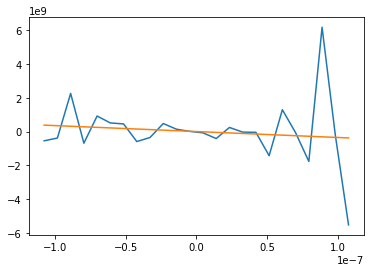

In [30]:
plt.plot(x_grid[12,:],kx_grid[12,:])
plt.plot(x_grid[12,:],a*x_grid[12,:])

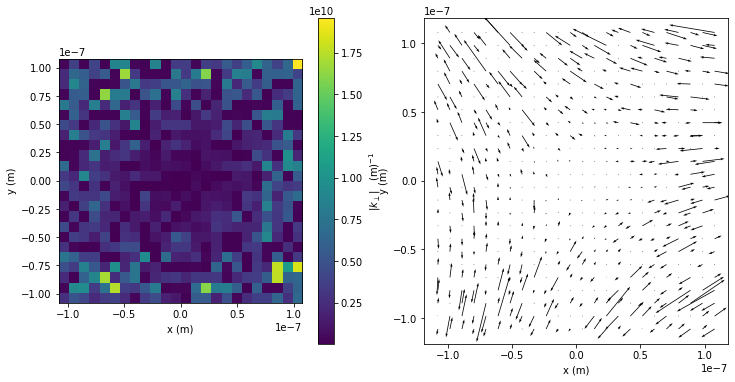

In [31]:
k_abs = np.power(np.power(kx_grid, 2) + np.power(ky_grid, 2), 0.5)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[12,6])
kmap = ax0.imshow(np.flip(k_abs, axis=0), extent=[x_grid[0,0], x_grid[-1,-1], y_grid[0,0], y_grid[-1,-1]])
ax0.set_xlabel("x (m)")
ax0.set_ylabel("y (m)")
cbar = fig.colorbar(kmap, ax=ax0)
cbar.set_label(r"$|k_\perp| \quad \mathrm{(m)}^{-1}$")
ax1.quiver(x_grid, y_grid, kx_grid, ky_grid)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
plt.show()
# fig.savefig('test.png')

In [15]:
emit_1 = np.power(kx_grid, 2) + np.power(ky_grid, 2)  # first term, absolute value of gradient of aberration function
emit_2 = np.power(x_grid, 2) + np.power(y_grid, 2)
emit_3 = kx_grid * x_grid + ky_grid * y_grid  # third term, cross term between x/y and gradient along x/y
emit = emit_1 * emit_2 - emit_3
emit[np.isnan(emit)] = 0
objective_state = np.sum(emit * mask)
print(np.sum(emit*mask))
print(np.log(np.sum(emit*mask)))

980137.1676395573
13.795447807831431


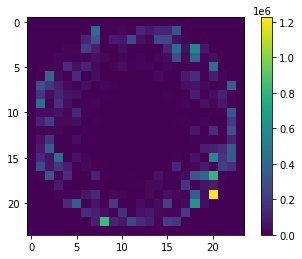

In [16]:
plt.imshow(emit*mask)
plt.colorbar()

In [9]:
x_grid, y_grid = np.meshgrid(np.linspace(-N/2, N/2, N),
                             np.linspace(-N/2, N/2, N))
temp = x_grid * x_grid + y_grid * y_grid
mask =temp < 144

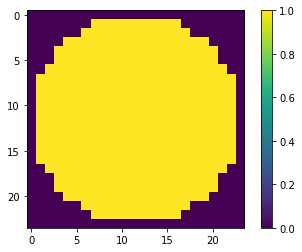

In [10]:
plt.imshow(mask)
plt.colorbar()

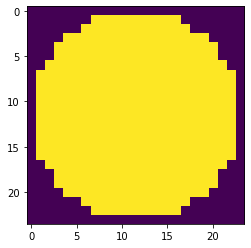

In [16]:
N = 24

# build a circular mask
x_grid, y_grid = np.meshgrid(np.linspace(-N/2, N/2, N),
                     np.linspace(-N/2, N/2, N))
temp = x_grid * x_grid + y_grid * y_grid
mask =temp < N*N/4
plt.imshow(mask)